In [1]:
import wf_psf
from wf_psf import SimPSFToolkit
from wf_psf import GenPolyFieldPSF
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
%pylab inline

import time
from tqdm import tqdm

# Pre-defined colormap
top = mpl.cm.get_cmap('Oranges_r', 128)
bottom = mpl.cm.get_cmap('Blues', 128)
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')



Populating the interactive namespace from numpy and matplotlib


In [2]:
def add_noise(image, desired_SNR):
    sigma_noise = np.sqrt((np.sum(image**2))/(desired_SNR * image.shape[0] * image.shape[1]))
    noisy_image = image + np.random.standard_normal(image.shape) * sigma_noise
    return noisy_image


In [3]:
# Zcube_path = '/Users/tliaudat/Documents/PhD/codes/WF_PSF/data/PA-zernike-cubes/Zernike45.mat'
Zcube_path = '/local/home/tliaudat/data/Zernike45.mat'
Zcube = sio.loadmat(Zcube_path)


In [4]:
# Parameters
d_max = 2
max_order = 45
x_lims = [0, 1e3]
y_lims = [0, 1e3]
grid_points = [4, 4]
n_bins = 20
verbose = True

oversampling_rate = 3.
output_Q = 3.

max_wfe_rms=0.1
output_dim=32
LP_filter_length=2
euclid_obsc = True
pupil_diameter = 256

n_stars = 2000
train_lim = int(n_stars*0.8)


zernikes = []
for it in range(45):
    zernikes.append(wf_psf.utils.downsample_im(input_im=Zcube['Zpols'][0,it][5], output_dim=pupil_diameter))

    
    
# Build param dicitionary
dataset_params = {'d_max':d_max, 'max_order':max_order, 'x_lims':x_lims, 'y_lims':y_lims,
                 'grid_points':grid_points, 'n_bins':n_bins, 'max_wfe_rms':max_wfe_rms,
                 'oversampling_rate':oversampling_rate, 'output_Q':output_Q,
                 'output_dim':output_dim, 'LP_filter_length':LP_filter_length,
                 'pupil_diameter':pupil_diameter, 'euclid_obsc':euclid_obsc,
                 'n_stars':n_stars, 'train_lim':train_lim}


# Initialize PSF simulator 
sim_PSF_toolkit = SimPSFToolkit.SimPSFToolkit(
    zernikes, max_order=max_order, max_wfe_rms=max_wfe_rms, oversampling_rate=oversampling_rate,
    output_Q=output_Q, output_dim=output_dim, pupil_diameter=pupil_diameter, euclid_obsc=euclid_obsc,
    LP_filter_length=LP_filter_length)

# Initialize PSF field 
gen_poly_fieldPSF = GenPolyFieldPSF.GenPolyFieldPSF(sim_PSF_toolkit, d_max=d_max,
                                    grid_points=grid_points, max_order=max_order,
                                    x_lims=x_lims, y_lims=y_lims, n_bins=n_bins,
                                    lim_max_wfe_rms=max_wfe_rms, verbose=verbose)


In [5]:
# Load the SEDs

# SED_path = '/Users/tliaudat/Documents/PhD/codes/WF_PSF/notebooks/explore_SEDs/save_SEDs/'
SED_path = '/local/home/tliaudat/data/'

stellar_SEDs = np.load(SED_path + 'SEDs.npy', allow_pickle=True)
stellar_lambdas = np.load(SED_path + 'lambdas.npy', allow_pickle=True)



In [6]:

SED_list = []

# Select SEDs
for it in range(n_stars):
    selected_id_SED = np.random.randint(low=0, high=13)
    concat_SED_wv = np.concatenate((stellar_lambdas.reshape(-1,1),
                                    stellar_SEDs[selected_id_SED,:].reshape(-1,1)), axis=1)
    SED_list.append(concat_SED_wv)
    



In [7]:
# First we choose the locations (randomly)
pos_np = np.random.rand(n_stars,2)

pos_np[:,0] = pos_np[:,0]*(x_lims[1] - x_lims[0]) + x_lims[0]
pos_np[:,1] = pos_np[:,1]*(y_lims[1] - y_lims[0]) + y_lims[0]

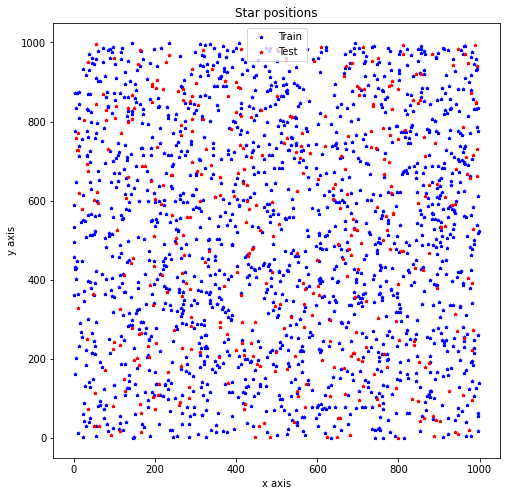

In [8]:
# Check out the positions

fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111)
im1 = ax1.scatter(pos_np[:train_lim,0], pos_np[:train_lim,1], s=10., c='blue', marker='*', label='Train')
im1 = ax1.scatter(pos_np[train_lim:,0], pos_np[train_lim:,1], s=10., c='red', marker='*', label='Test')
ax1.set_title('Star positions')
ax1.set_xlabel('x axis')
ax1.set_ylabel('y axis')
ax1.legend()
plt.show()



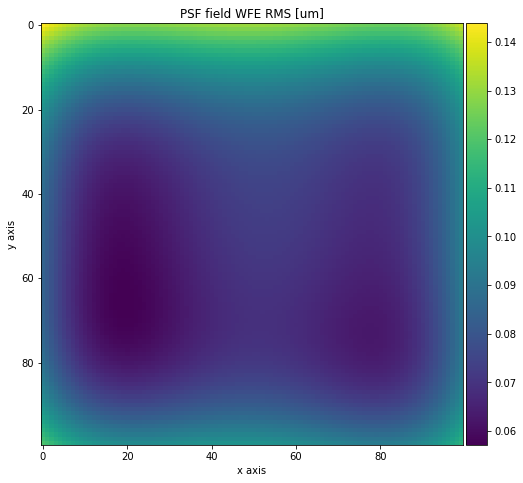

In [9]:
gen_poly_fieldPSF.show_WFE_RMS()

In [10]:
# Generate the PSFs
poly_psf_list = []
zernike_coef_list = []

for it in tqdm(range(n_stars)):
    _psf, _zernike, _ = gen_poly_fieldPSF.get_poly_PSF(xv_flat=pos_np[it, 0],
                                                       yv_flat=pos_np[it, 1],
                                                       SED=SED_list[it])
    
    poly_psf_list.append(_psf)
    zernike_coef_list.append(_zernike)



 63%|██████▎   | 1259/2000 [30:04<17:42,  1.43s/it]


KeyboardInterrupt: 

In [ ]:
gen_poly_fieldPSF.show_WFE_RMS(save_img=True)

In [ ]:
# Generate numpy arrays from the lists
poly_psf_np = np.array(poly_psf_list)
zernike_coef_np = np.array(zernike_coef_list)
SED_np = np.array(SED_list)

In [ ]:
print(poly_psf_np.shape)
print(zernike_coef_np.shape)
print(SED_np.shape)
print(pos_np.shape)

In [ ]:
# Generate the noisy train stars

# Copy the training stars
noisy_train_stars = np.copy(poly_psf_np[:train_lim, :, :])

# Generate a dataset with a SNR varying randomly from 10 to 80
rand_SNR = (np.random.rand(noisy_train_stars.shape[0]) * 70) + 10

noisy_train_stars = np.stack([add_noise(_im, desired_SNR=_SNR) for _im, _SNR in zip(noisy_train_stars, rand_SNR)], axis=0)




In [ ]:
# Generate dictionary and save

C_poly = gen_poly_fieldPSF.C_poly

train_psf_dataset = {'stars' : poly_psf_np[:train_lim, :, :],
                     'noisy_stars': noisy_train_stars,
                     'positions' : pos_np[:train_lim, :],
                     'SEDs' : SED_np[:train_lim, :, :],
                     'zernike_coef' : zernike_coef_np[:train_lim, :, :],
                     'C_poly' : C_poly,
                     'parameters': dataset_params}

test_psf_dataset = {'stars' : poly_psf_np[train_lim:, :, :],
                     'positions' : pos_np[train_lim:, :],
                     'SEDs' : SED_np[train_lim:, :, :],
                     'zernike_coef' : zernike_coef_np[train_lim:, :, :],
                     'C_poly' : C_poly,
                     'parameters': dataset_params}



In [ ]:
# output_folder = '/Users/tliaudat/Documents/PhD/codes/WF_PSF/notebooks/psf_field_datasets/Euclid_resolution/'
output_folder = '/local/home/tliaudat/psf-datasets/'

np.save(output_folder + 'train_Euclid_res_2k_stars_dim256.npy', train_psf_dataset, allow_pickle=True)
np.save(output_folder + 'test_Euclid_res_2k_stars_dim256.npy', test_psf_dataset, allow_pickle=True)



## Now without the x4 stars of the dither

In [16]:
new_n_stars = int(n_stars/4)
new_train_lim = int(new_n_stars*0.8)
train_stars = new_n_stars - new_train_lim

# Generate dictionary and save

C_poly = gen_poly_fieldPSF.C_poly

train_psf_dataset = {'stars' : poly_psf_np[:new_train_lim, :, :],
                     'positions' : pos_np[:new_train_lim, :],
                     'SEDs' : SED_np[:new_train_lim, :, :],
                     'zernike_coef' : zernike_coef_np[:new_train_lim, :, :],
                     'C_poly' : C_poly,
                     'parameters': dataset_params}

test_psf_dataset = {'stars' : poly_psf_np[train_lim:train_lim+train_stars, :, :],
                     'positions' : pos_np[train_lim:train_lim+train_stars, :],
                     'SEDs' : SED_np[train_lim:train_lim+train_stars, :, :],
                     'zernike_coef' : zernike_coef_np[train_lim:train_lim+train_stars, :, :],
                     'C_poly' : C_poly,
                     'parameters': dataset_params}



In [17]:
# Build param dicitionary
dataset_params = {'d_max':d_max, 'max_order':max_order, 'x_lims':x_lims, 'y_lims':y_lims,
                 'grid_points':grid_points, 'n_bins':n_bins, 'max_wfe_rms':max_wfe_rms,
                 'oversampling_rate':oversampling_rate, 'output_Q':output_Q,
                 'output_dim':output_dim, 'LP_filter_length':LP_filter_length,
                 'pupil_diameter':pupil_diameter, 'euclid_obsc':euclid_obsc,
                 'n_stars':new_n_stars, 'train_lim':new_train_lim}


In [18]:
output_folder = '/Users/tliaudat/Documents/PhD/codes/WF_PSF/notebooks/psf_field_datasets/Euclid_resolution/'

np.save(output_folder + 'train_Euclid_res_200stars_dim512.npy', train_psf_dataset, allow_pickle=True)
np.save(output_folder + 'test_Euclid_res_200stars_dim512.npy', test_psf_dataset, allow_pickle=True)




In [20]:
train_psf_dataset['stars'].shape

(160, 32, 32)

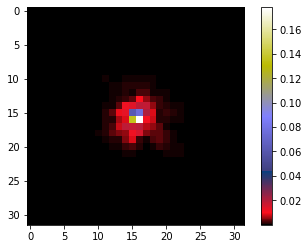

In [22]:
it=52

imshow(train_psf_dataset['stars'][it,:,:], cmap='gist_stern');colorbar()
